In [1]:
import pandas as pd
from perturbationx import CausalNetwork

In [2]:
my_cbn = CausalNetwork.from_tsv("data/NPANetworks/Hs_CFA_Apoptosis_backbone.tsv", edge_type="core")
my_cbn.add_edges_from_tsv("data/NPANetworks/Hs_CFA_Apoptosis_downstream.tsv", edge_type="boundary")

In [6]:
datasets = dict()

datasets["CS (2m) + Sham (3m)"] = pd.read_table("./data/COPD1/CS (2m) + Sham (3m).tsv")
datasets["CS (2m) + Sham (5m)"] = pd.read_table("./data/COPD1/CS (2m) + Sham (5m).tsv")
datasets["CS (4m) + Sham (1m)"] = pd.read_table("./data/COPD1/CS (4m) + Sham (1m).tsv")
datasets["CS (4m) + Sham (3m)"] = pd.read_table("./data/COPD1/CS (4m) + Sham (3m).tsv")
datasets["CS (5m)"] = pd.read_table("./data/COPD1/CS (5m).tsv")
datasets["CS (7m)"] = pd.read_table("./data/COPD1/CS (7m).tsv")

for data_id, dataset in datasets.items():
    datasets[data_id] = dataset.rename(columns={"nodeLabel": "nodeID", "foldChange": "logFC"})

In [7]:
results = my_cbn.compute_npa(datasets)

2023-05-18 10:11:26,319 INFO -- PREPROCESSING NETWORK
2023-05-18 10:11:26,450 INFO -- core edges: 230, boundary edges: 11114
2023-05-18 10:11:26,451 INFO -- core nodes: 133, outer boundary nodes: 5729
2023-05-18 10:11:26,451 INFO -- inner boundary nodes: 67
2023-05-18 10:11:38,085 INFO -- COMPUTING NPA FOR DATASET 'CS (2m) + Sham (3m)'
2023-05-18 10:11:38,094 INFO -- boundary nodes matched with dataset: 5225
2023-05-18 10:11:49,911 INFO -- COMPUTING NPA FOR DATASET 'CS (2m) + Sham (5m)'
2023-05-18 10:11:49,921 INFO -- boundary nodes matched with dataset: 5225
2023-05-18 10:11:58,675 INFO -- COMPUTING NPA FOR DATASET 'CS (4m) + Sham (1m)'
2023-05-18 10:11:58,686 INFO -- boundary nodes matched with dataset: 5225
2023-05-18 10:12:07,075 INFO -- COMPUTING NPA FOR DATASET 'CS (4m) + Sham (3m)'
2023-05-18 10:12:07,085 INFO -- boundary nodes matched with dataset: 5225
2023-05-18 10:12:11,460 INFO -- COMPUTING NPA FOR DATASET 'CS (5m)'
2023-05-18 10:12:11,470 INFO -- boundary nodes matched wit

In [8]:
display(results.global_info())

,NPA,variance,ci_lower,ci_upper,o_value,k_value
CS (2m) + Sham (3m),0.007157,3.612355e-06,0.003432,0.010882,0.000,0.106
CS (2m) + Sham (5m),0.001191,2.181921e-07,0.000275,0.002107,0.082,0.384
CS (4m) + Sham (1m),0.076700,1.599542e-05,0.068861,0.084539,0.000,0.028
CS (4m) + Sham (3m),0.036512,9.365318e-06,0.030514,0.042510,0.000,0.064
CS (5m),0.102559,1.526669e-05,0.094901,0.110217,0.000,0.028
CS (7m),0.085898,1.909044e-05,0.077335,0.094462,0.000,0.028


In [7]:
display(results.node_info("CS (5m)"))

attr,contribution,coefficient,variance,ci_lower,ci_upper,p_value
act(p(MGI:Tnfrsf10b)),0.002914,0.092696,0.000030,0.082017,0.103374,0.000000e+00
act(p(MGI:Tlr4)),0.000903,0.083621,0.000007,0.078431,0.088812,0.000000e+00
p(MGI:Fasl),0.008193,0.219812,0.000036,0.208104,0.231521,0.000000e+00
"act(complex(GOCC:""mitochondrial permeability transition pore complex""))",0.016611,0.255549,0.000025,0.245846,0.265252,0.000000e+00
"act(p(SFAM:""PRKA Family""))",0.000260,-0.029584,0.000016,-0.037354,-0.021815,4.229950e-14
...,...,...,...,...,...,...
act(p(MGI:Map3k7)),0.000924,0.072456,0.000355,0.035521,0.109390,6.029602e-05
p(MGI:Stat3),0.000281,0.040692,0.000007,0.035680,0.045703,0.000000e+00
p(MGI:Tnfrsf1a),0.005713,0.183557,0.000025,0.173789,0.193324,0.000000e+00
"a(SCHEM:""Phosphatidylinositol-3,4,5-trisphosphate"")",0.000021,0.011127,0.000030,0.000370,0.021883,2.131076e-02


In [9]:
results.node_attributes()

['contribution', 'coefficient', 'variance', 'ci_lower', 'ci_upper', 'p_value']

In [9]:
display(results.node_info("contribution"))

data,CS (5m),CS (7m)
act(p(MGI:Tnfrsf10b)),0.002914,0.002986
act(p(MGI:Tlr4)),0.000903,0.000535
p(MGI:Fasl),0.008193,0.009685
"act(complex(GOCC:""mitochondrial permeability transition pore complex""))",0.016611,0.016322
"act(p(SFAM:""PRKA Family""))",0.000260,0.000288
...,...,...
act(p(MGI:Map3k7)),0.000924,0.000038
p(MGI:Stat3),0.000281,0.000285
p(MGI:Tnfrsf1a),0.005713,0.005919
"a(SCHEM:""Phosphatidylinositol-3,4,5-trisphosphate"")",0.000021,0.000008


In [13]:
for d in results.datasets():
    values = results.node_info("contribution")[d].to_dict()
    print(values)

{'act(complex(SCOMP:"Nfkb Complex"))': 0.0001804754731128689, 'p(MGI:Fasl)': 0.005295661438978998, 'act(p(SFAM:"AKT Family"))': 0.014030256976249258, 'act(p(MGI:Dffa))': 0.0013725281423219004, 'act(p(MGI:Rela))': 0.0024159309765942965, 'act(p(MGI:Bad))': 0.013318028713701822, 'p(MGI:Tlr4)': 0.0024252998948527376, 'act(p(MGI:Ep300))': 0.00043637802135504936, 'p(MGI:Tnfrsf10b)': 0.002280446855350541, 'p(MGI:Bcl2a1b)': 0.0002843352633071266, 'act(p(MGI:Akt2))': 0.00836791765371085, 'act(p(MGI:Fas))': 0.02147137820178909, 'act(p(MGI:Mapk10))': 6.13673352070862e-05, 'act(complex(GOCC:"mitochondrial permeability transition pore complex"))': 0.018653931647016276, 'act(p(MGI:Tradd))': 0.026074218713919028, 'p(MGI:Bcl2l1)': 0.002663886873447179, 'a(SCHEM:Calcium)': 0.0008541738699375782, 'act(p(MGI:Pdpk1))': 0.00010700020939351912, 'p(MGI:Cflar)': 0.0011507699751299345, 'act(p(MGI:Mapk1))': 0.00022518654083958776, 'act(p(MGI:Bmx))': 0.0036778775142161557, 'act(p(MGI:Nkx3-1))': 0.108084605695902

In [11]:
results.distributions()

['o_distribution', 'k_distribution']

<Figure size 640x480 with 0 Axes>

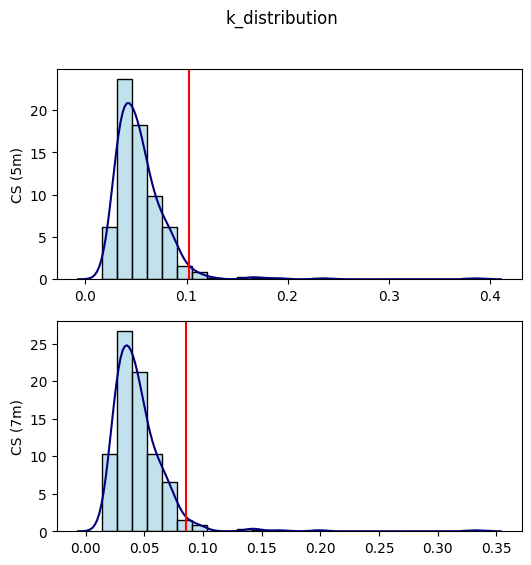

array([<Axes: ylabel='CS (5m)'>, <Axes: ylabel='CS (7m)'>], dtype=object)

In [11]:
results.plot_distribution('k_distribution')

In [5]:
import py4cytoscape as p4c
p4c.cytoscape_version_info()

2023-05-13 18:32:07,930 DEBUG -- Calling cytoscape_version_info()
2023-05-13 18:32:07,931 DEBUG -- ǀCalling cyrest_get('version', base_url='http://127.0.0.1:1234/v1')
2023-05-13 18:32:07,933 DEBUG -- Attempting to direct connect to Cytoscape on http://127.0.0.1:1234/v1
2023-05-13 18:32:07,966 DEBUG -- Detected py4cytoscape running on Cytoscape workstation
2023-05-13 18:32:07,968 DEBUG -- ǀHTTP GET(http://127.0.0.1:1234/v1/version)
2023-05-13 18:32:07,981 DEBUG -- ǀOK[200], content: {"apiVersion":"v1","cytoscapeVersion":"3.10.0"}
2023-05-13 18:32:07,983 DEBUG -- ǀReturning 'cyrest_get': {'apiVersion': 'v1', 'cytoscapeVersion': '3.10.0'}
2023-05-13 18:32:07,985 DEBUG -- Returning 'cytoscape_version_info': {'apiVersion': 'v1', 'cytoscapeVersion': '3.10.0', 'automationAPIVersion': '1.6.0', 'py4cytoscapeVersion': '1.6.0'}
2023-05-13 18:32:07,987 DEBUG -- --------------------


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.10.0',
 'automationAPIVersion': '1.6.0',
 'py4cytoscapeVersion': '1.6.0'}

In [10]:
results.display_network(display_boundary=False)

976010

In [6]:
results.color_nodes("contribution", "CS (5m)")

In [5]:
results.export("results.json")